In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['export OPENBLAS_NUM_THREADS']='2'

In [2]:
import torch
import torch.nn as nn
import torch.fft
import numpy as np
from scipy.io import loadmat, savemat
import math
import os
import h5py
import matplotlib.pyplot as plt
from functools import partial
from models.models import MWT2d
from models.utils import train, test, LpLoss, get_filter, UnitGaussianNormalizer

In [3]:
print(torch.__version__)

1.13.1+cu117


In [4]:
torch.manual_seed(0)
np.random.seed(0)

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def get_initializer(name):
    
    if name == 'xavier_normal':
        init_ = partial(nn.init.xavier_normal_)
    elif name == 'kaiming_uniform':
        init_ = partial(nn.init.kaiming_uniform_)
    elif name == 'kaiming_normal':
        init_ = partial(nn.init.kaiming_normal_)
    return init_

In [31]:
data_path = 'Data/2D_much.npy'
ntrain = 12100
ntest = 1540

r = 1
h = int(((64 - 1)/r) + 1)
s = h

dataloader = np.load(data_path)
print(dataloader.shape)
u_data = dataloader.astype(np.float32)

x_train = torch.from_numpy(u_data[:ntrain, ::r,::r, 0])
y_train = torch.from_numpy(u_data[:ntrain, ::r,::r, 1])

x_test = torch.from_numpy(u_data[-ntest:, ::r,::r, 0])
y_test = torch.from_numpy(u_data[-ntest:, ::r,::r, 1])

print(x_test[0, 0, 0])

(14120, 64, 64, 2)
tensor(29.2424)


In [9]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s,s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

In [10]:
# # data_path = 'Data/melt64/melting.npy'
# data_path = 'Data/melt64/melting.npy'
# dataloader = np.load(data_path)

# ntrain = 170
# ntest = 30

# r = 1
# h = int(((64 - 1)/r) + 1)
# s = h

In [11]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [12]:
ich = 3
initializer = get_initializer('xavier_normal') # xavier_normal, kaiming_normal, kaiming_uniform

torch.manual_seed(0)
np.random.seed(0)

model = MWT2d(ich, 
            alpha = 12,
            c = 4,
            k = 4, 
            base = 'legendre', # 'chebyshev'
            nCZ = 4,
            L = 0,
            initializer = initializer,
            ).to(device)

learning_rate = 0.001
epochs = 5000
step_size = 100
gamma = 0.5

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()

In [14]:
# train_loss = []
# test_loss = []
# for epoch in range(1, epochs+1):
#     train_l2 = train(model, train_loader, optimizer, epoch, device,
#         lossFn = myloss, lr_schedule = scheduler,
#         post_proc = y_normalizer.decode)
#     train_loss.append(train_l2)
#     test_l2 = test(model, test_loader, device, lossFn=myloss, post_proc=y_normalizer.decode)
#     print(f'epoch: {epoch}, train l2 = {train_l2}, test l2 = {test_l2}')
#     test_loss.append(test_l2)
        
#     if epoch%100 == 0:
#         PATH = 'NS_models/final_exp/altered_model{}.pt'.format(epoch)
#         torch.save({'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': myloss}, PATH)
        
#         np.save('visual/train_loss_2D_final.npy', train_loss)
#         np.save('visual/test_loss_2D_final.npy', test_loss)

In [15]:
PATH = 'NS_models/final_exp/altered_model1700.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

MWT2d(
  (Lk): Linear(in_features=3, out_features=64, bias=True)
  (MWT_CZ): ModuleList(
    (0): MWT_CZ2d(
      (A): sparseKernelFT2d(
        (Lo): Linear(in_features=64, out_features=64, bias=True)
      )
      (B): sparseKernel2d(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
        (Lo): Linear(in_features=64, out_features=64, bias=True)
      )
      (C): sparseKernel2d(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
        (Lo): Linear(in_features=64, out_features=64, bias=True)
      )
      (T0): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): MWT_CZ2d(
      (A): sparseKernelFT2d(
        (Lo): Linear(in_features=64, out_features=64, bias=True)
      )
      (B): sparseKernel2d(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_si

In [16]:
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()
        out = model(x)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

0 0.9972923398017883
1 0.9974079132080078
2 0.997514545917511
3 0.9976149201393127
4 0.9977074265480042
5 0.997802734375
6 0.9979013204574585
7 0.9980036020278931
8 0.9981092810630798
9 0.9982188940048218
10 0.998333752155304
11 0.9984538555145264
12 0.9985789060592651
13 0.9987088441848755
14 0.9988452792167664
15 0.9989888072013855
16 0.9991390705108643
17 0.9992974996566772
18 0.9994638562202454
19 0.9996384382247925
20 0.9998235702514648
21 1.000019907951355
22 1.000229001045227
23 1.0004525184631348
24 1.0006910562515259
25 1.000946044921875
26 1.0012195110321045
27 1.0015125274658203
28 1.0018283128738403
29 1.0021733045578003
30 1.002545714378357
31 1.0029505491256714
32 1.003395676612854
33 1.0038856267929077
34 1.0044256448745728
35 1.0050181150436401
36 1.0056755542755127
37 1.006413459777832
38 1.0072393417358398
39 1.008162498474121
40 1.0091896057128906
41 1.010345220565796
42 1.0116385221481323
43 1.0130525827407837
44 1.0146158933639526
45 1.0163240432739258
46 1.0181745

366 1.0457872152328491
367 1.0457881689071655
368 1.045789122581482
369 1.0457898378372192
370 1.045790433883667
371 1.0457907915115356
372 1.045791506767273
373 1.045791745185852
374 1.0457921028137207
375 1.0457924604415894
376 1.045792579650879
377 1.0457926988601685
378 1.0457929372787476
379 1.0457931756973267
380 1.0457932949066162
381 1.0457931756973267
382 1.0457932949066162
383 1.0457934141159058
384 1.0457934141159058
385 1.0457934141159058
386 1.0457934141159058
387 1.0457934141159058
388 1.0457934141159058
389 1.0457934141159058
390 1.0457934141159058
391 1.0457932949066162
392 1.0457932949066162
393 1.0457931756973267
394 1.0457932949066162
395 1.0457932949066162
396 1.0457931756973267
397 1.0457931756973267
398 1.0457931756973267
399 1.045793056488037
400 1.045793056488037
401 1.045793056488037
402 1.0457929372787476
403 1.0457929372787476
404 1.0457929372787476
405 1.045792818069458
406 1.045792818069458
407 1.045792818069458
408 1.045792818069458
409 1.0457926988601685


731 1.0451971292495728
732 1.0452632904052734
733 1.0453206300735474
734 1.0453708171844482
735 1.0454151630401611
736 1.0454535484313965
737 1.0454881191253662
738 1.045519232749939
739 1.0455471277236938
740 1.045572280883789
741 1.0455950498580933
742 1.0456156730651855
743 1.045634150505066
744 1.045650839805603
745 1.0456658601760864
746 1.0456795692443848
747 1.045691728591919
748 1.0457029342651367
749 1.0457130670547485
750 1.045722246170044
751 1.0457305908203125
752 1.0457381010055542
753 1.045744776725769
754 1.0457507371902466
755 1.0457561016082764
756 1.0457608699798584
757 1.0457650423049927
758 1.0457688570022583
759 1.0457719564437866
760 1.0457749366760254
761 1.045777440071106
762 1.0457795858383179
763 1.0457816123962402
764 1.045783281326294
765 1.0457847118377686
766 1.0457861423492432
767 1.0457870960235596
768 1.045788049697876
769 1.0457888841629028
770 1.0457895994186401
771 1.045790195465088
772 1.045790672302246
773 1.0457910299301147
774 1.0457913875579834


1088 1.0455176830291748
1089 1.0455456972122192
1090 1.045570731163025
1091 1.0455937385559082
1092 1.04561448097229
1093 1.04563307762146
1094 1.045649766921997
1095 1.04566490650177
1096 1.0456786155700684
1097 1.0456910133361816
1098 1.0457022190093994
1099 1.0457123517990112
1100 1.0457216501235962
1101 1.0457301139831543
1102 1.045737624168396
1103 1.0457442998886108
1104 1.045750379562378
1105 1.0457556247711182
1106 1.0457603931427002
1107 1.045764684677124
1108 1.0457683801651
1109 1.0457717180252075
1110 1.0457745790481567
1111 1.0457772016525269
1112 1.0457793474197388
1113 1.0457812547683716
1114 1.0457830429077148
1115 1.0457844734191895
1116 1.0457857847213745
1117 1.0457868576049805
1118 1.0457878112792969
1119 1.0457886457443237
1120 1.045789361000061
1121 1.0457899570465088
1122 1.045790433883667
1123 1.0457907915115356
1124 1.0457912683486938
1125 1.0457916259765625
1126 1.0457919836044312
1127 1.0457921028137207
1128 1.0457924604415894
1129 1.045792579650879
1130 1.04

1436 1.0457170009613037
1437 1.0457212924957275
1438 1.0457297563552856
1439 1.0457372665405273
1440 1.0457384586334229
1441 1.0457441806793213
1442 1.0457500219345093
1443 1.045754313468933
1444 1.045755386352539
1445 1.045760154724121
1446 1.045764446258545
1447 1.0457661151885986
1448 1.045768141746521
1449 1.0457714796066284
1450 1.0457743406295776
1451 1.0457744598388672
1452 1.0457769632339478
1453 1.0457791090011597
1454 1.0457805395126343
1455 1.045781135559082
1456 1.0457828044891357
1457 1.0457842350006104
1458 1.0457847118377686
1459 1.0457855463027954
1460 1.0457866191864014
1461 1.0457876920700073
1462 1.0457878112792969
1463 1.0457885265350342
1464 1.0457892417907715
1465 1.0457895994186401
1466 1.0457897186279297
1467 1.0457903146743774
1468 1.0457907915115356
1469 1.0457907915115356
1470 1.0457911491394043
1471 1.045791506767273
1472 1.045791745185852
1473 1.0457918643951416
1474 1.0457921028137207
1475 1.0457923412322998
1476 1.0457924604415894
1477 1.045792579650879
1

In [17]:
total_loss = 0.
predictions = []
post_proc=y_normalizer.decode

with torch.no_grad():
    for data, target in test_loader:
        bs = len(data)

        data, target = data.to(device), target.to(device)
        output = model(data)
        output = post_proc(output)

        loss = myloss(output.view(bs, -1), target.view(bs, -1))
        predictions.extend(output.cpu().data.numpy())
        total_loss += loss.sum().item()

predictions = torch.Tensor(predictions)
predictions = torch.reshape(predictions, y_test.shape)

/tmp/ipykernel_1392271/97861832.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  predictions = torch.Tensor(predictions)


In [18]:
print('x_test.mean.shape', x_test[29, :, :, 0])
print('test_u[0].shape', y_test.shape)
print('predictions', predictions.shape)
print('total loss = ', total_loss)

x_test.mean.shape tensor([[-0.7153, -0.7153, -0.7153,  ..., -0.7153, -0.7153, -0.7153],
        [-0.7103, -0.7103, -0.7103,  ..., -0.7103, -0.7103, -0.7103],
        [-0.7050, -0.7050, -0.7050,  ..., -0.7050, -0.7050, -0.7050],
        ...,
        [ 0.1835,  0.1835,  0.1835,  ...,  0.1835,  0.1835,  0.1835],
        [ 0.2062,  0.2062,  0.2062,  ...,  0.2062,  0.2062,  0.2062],
        [ 0.2286,  0.2286,  0.2286,  ...,  0.2286,  0.2286,  0.2286]])
test_u[0].shape torch.Size([1540, 64, 64])
predictions torch.Size([1540, 64, 64])
total loss =  156.1814677193761


In [40]:
def plot_loss(initial, prediction, test, index):
    initial = initial[index]
    test = test[index]
    prediction = prediction[index]
    
    loss = abs(torch.sub(test, prediction))

    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    
    cp4 = axs[0, 0].matshow(initial)
    axs[0, 0].set_title('Input field', fontsize=20)
    axs[0, 0].xaxis.set_tick_params(labelsize=18)
    axs[0, 0].yaxis.set_tick_params(labelsize=18)
    cp4 = fig.colorbar(cp4)
    cp4.ax.tick_params(labelsize=18)

    cp1 = axs[0, 1].matshow(test)
    axs[0, 1].set_title('True velocity field', fontsize=20)
    axs[0, 1].xaxis.set_tick_params(labelsize=18)
    axs[0, 1].yaxis.set_tick_params(labelsize=18)
    cp1 = fig.colorbar(cp1)
    cp1.ax.tick_params(labelsize=18)
    
    cp2 = axs[1, 1].matshow(prediction)
    axs[1, 1].set_title('Predicted velocity field', fontsize=20)
    axs[1, 1].xaxis.set_tick_params(labelsize=18)
    axs[1, 1].yaxis.set_tick_params(labelsize=18)
    cp2 = fig.colorbar(cp2)
    cp2.ax.tick_params(labelsize=18)
    
    cp3 = axs[1, 0].matshow(loss)
    axs[1, 0].set_title('Absolute difference between model \n prediction and true value', fontsize=20)
    axs[1, 0].xaxis.set_tick_params(labelsize=18)
    axs[1, 0].yaxis.set_tick_params(labelsize=18)
    cp3 = fig.colorbar(cp3)
    cp3.ax.tick_params(labelsize=18)
    
    
#     train = np.load('visual/train_loss_2D_altered.npy')
#     test = np.load('visual/test_loss_2D_altered.npy')
#     axs[1, 1].plot(train[100:1100], label = 'Train loss')
#     axs[1, 1].plot(test[100:1100], label = 'Test loss')
#     axs[1, 1].set_title('End of predicted field', fontsize=20)
#     axs[1, 1].xaxis.set_tick_params(labelsize=18)
#     axs[1, 1].yaxis.set_tick_params(labelsize=18)
#     axs[1, 1].tick_params(labelsize=18)
#     axs[1, 1].legend(prop={'size': 18})
    fig.show()

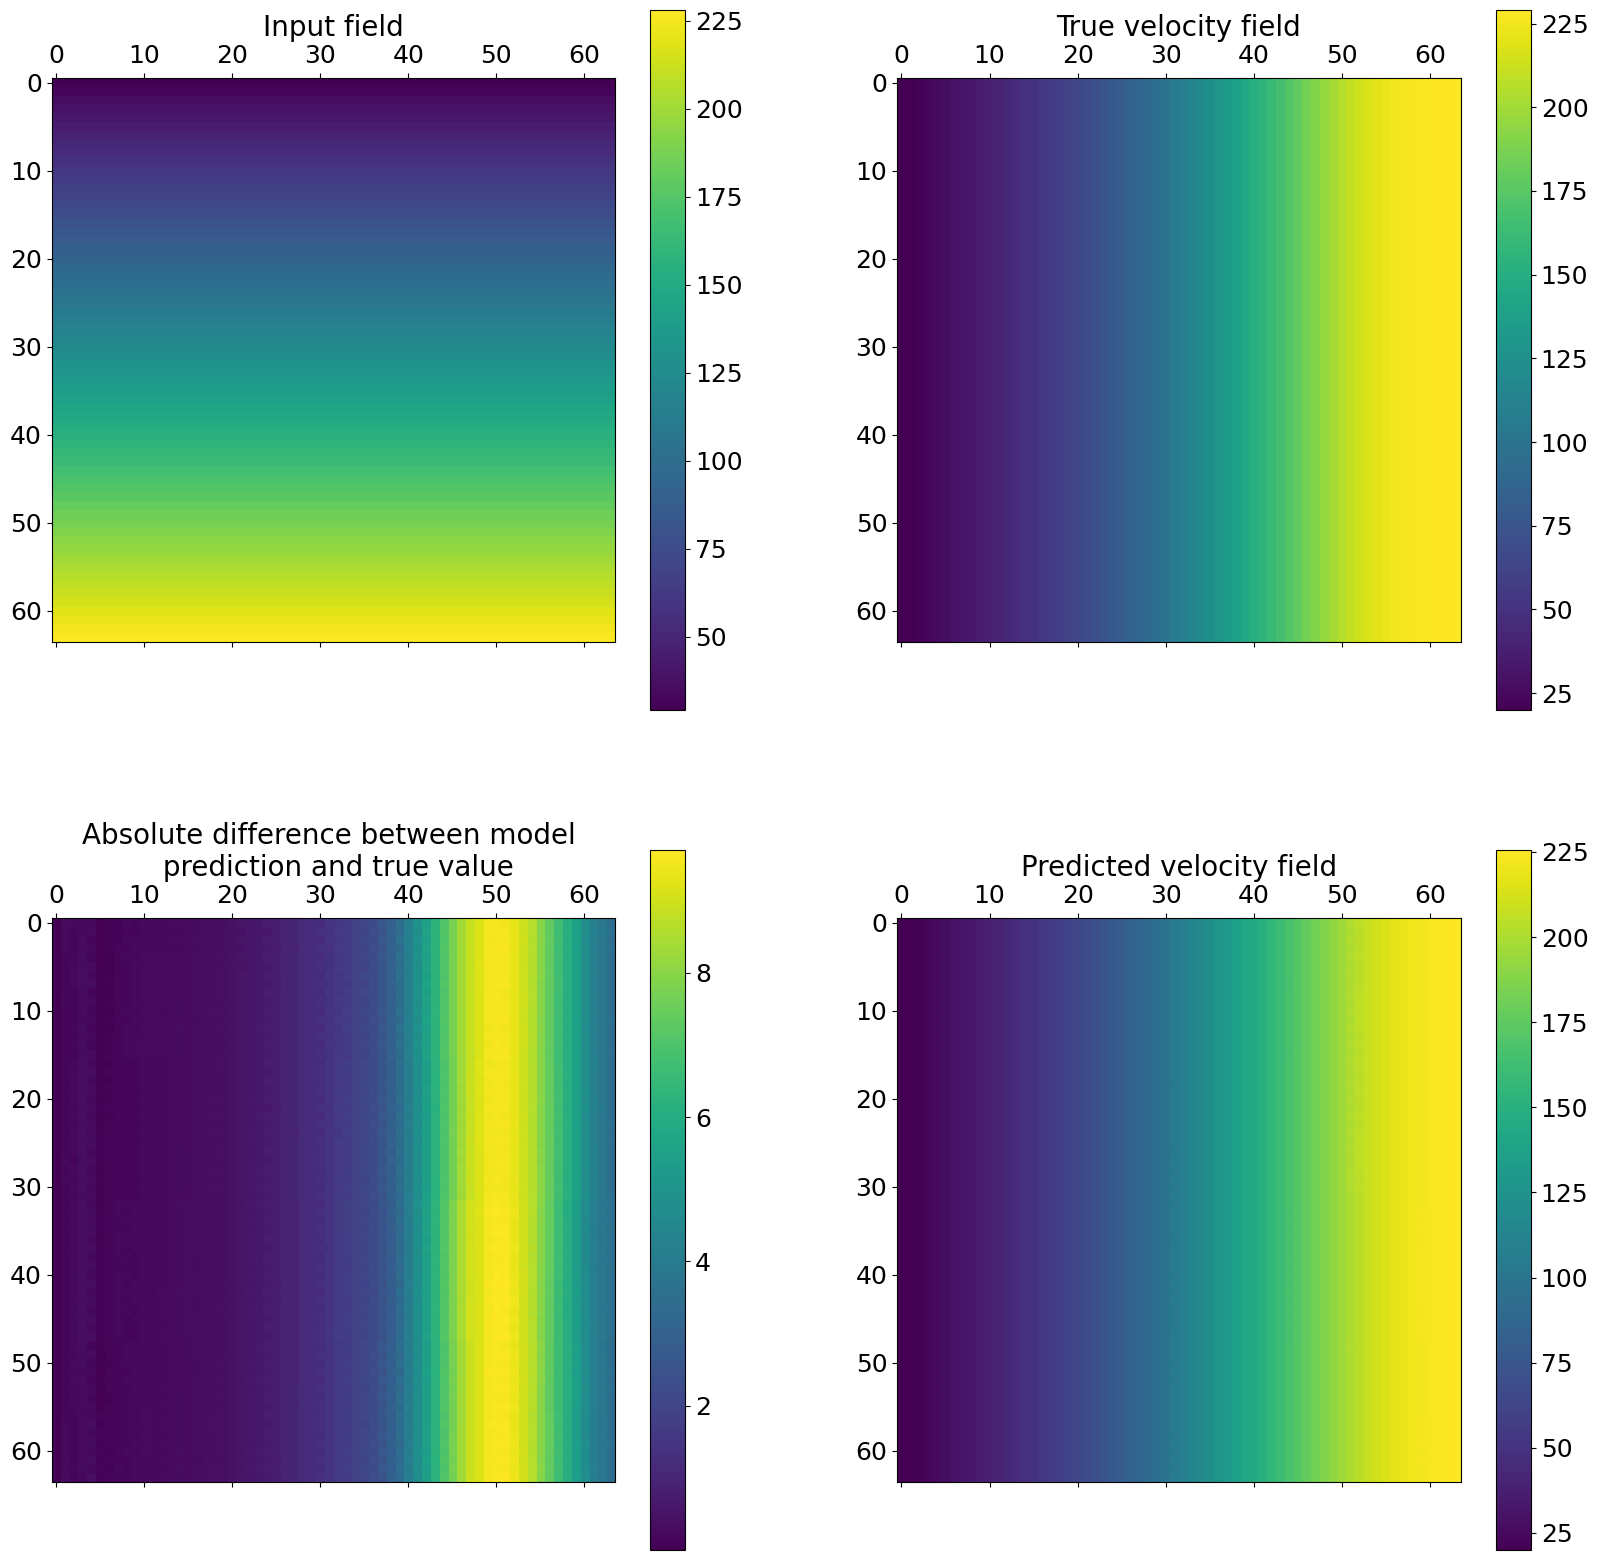

In [43]:
plot_loss(x_test, predictions, y_test, 1)

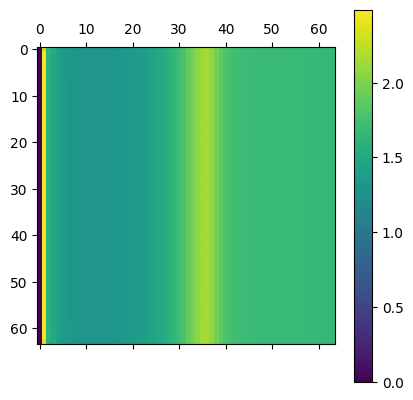

In [21]:
cp1 = plt.matshow(y_train[0])
plt.colorbar(cp1)